In [39]:
%matplotlib inline
import numpy
import matplotlib
from matplotlib import pyplot, rcParams, animation

rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [119]:
#Define grid parameters
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

#Tolerance
l1_target = 1e-6; L1_norm = 1e10;

#Global variables
Utop = 1.0;
psi = numpy.zeros((ny,nx));
wz = numpy.zeros((ny,nx));

In [120]:
#Define Poisson solver:
def Poisson_solve (u, unew, source, dx, dy):
    
    m = numpy.size(u[0,:])
    n = numpy.size(u[:,0])

    #unew = numpy.zeros_like(u)
    
    dxdy2inv = 1.0/(dx**2) + 1.0/(dy**2)
    
    # Solve Laplacian(u) = source
    # Currently uses Jacobi. Learn JIT and implement Gauss-Seidel
    unew[1:-1,1:-1] = 0.5/dxdy2inv * ( \
                        (u[1:-1,2:]+u[1:-1,:-2])/(dx**2) + \
                        (u[2:,1:-1]+u[:-2,1:-1])/(dy**2) - \
                        source[1:-1,1:-1] );
    
    return unew;

In [121]:
#Define initial conditions:
def init_psi_wz (nx, ny):
    
    sf = numpy.zeros((ny,nx)); 
    vort = numpy.zeros_like(sf);
    
    #Top edge
    vort[-1,:] = -0.5/(dy**2)*(8*sf[-2,:] - sf[-3,:]) -3/dy*Utop;
    
    return (sf, vort);

In [122]:
#Define boundary conditions:
def BC_wz (psi, wz):
    
    #Boundary conditions on vorticity:
    #Left edge (No tangential velocity):
    wz[:,0] = -0.5/(dx**2)*(8*psi[:,1] - psi[:,2]);
    #Right edge (No tangential velocity):
    wz[:,-1] = -0.5/(dx**2)*(8*psi[:,-2] - psi[:,-3]);
    #Bottom edge (No tangential velocity):
    wz[0,:] = -0.5/(dy**2)*(8*psi[1,:] - psi[2,:]);
    #Top edge (Tangential velocity = Utop):
    wz[-1,:] = -0.5/(dy**2)*(8*psi[-2,:] - psi[-3,:]) -3/dy*Utop;
    
    return wz;

In [123]:
#Define boundary conditions:
def BC_psi (psi, wz):
    
    #Boundary conditions on streamfunctions:
    psi[:,0] = 0; psi[:,-1] = 0; psi[0,:] = 0; psi[-1,:] = 0;
    
    return psi;

In [124]:
def L1norm_fun(new, old):
    
    norm = numpy.sum(numpy.abs(new-old))
    
    return norm;

In [135]:
nullmat = numpy.zeros_like(wz)

psi, wz = init_psi_wz(nx,ny);
iter = 0

while (L1_norm >= l1_target):
    wz_new = Poisson_solve(wz, wz_new, nullmat, dx, dy);
    wz_new = BC_wz(psi, wz_new);
    
    psi_new = Poisson_solve(psi, psi_new, -1.0*wz_new, dx, dy);
    psi_new = BC_psi(psi_new, wz_new);
    
    L1_norm = L1norm_fun(psi_new,psi)
    
    wz = numpy.copy(wz_new);
    psi = numpy.copy(psi_new);
    iter = iter + 1

print('Max value of abs(psi):',numpy.max(numpy.abs(psi_new)))
print('Max value of abs(wz):',numpy.max(numpy.abs(wz_new[1:,1:-1])))
numpy.round(psi_new[32,::8], 4)

Max value of abs(psi): 0.0998447258637
Max value of abs(wz): 78.1926609601


array([ 0.    , -0.0575, -0.0944, -0.0944, -0.0575,  0.    ])

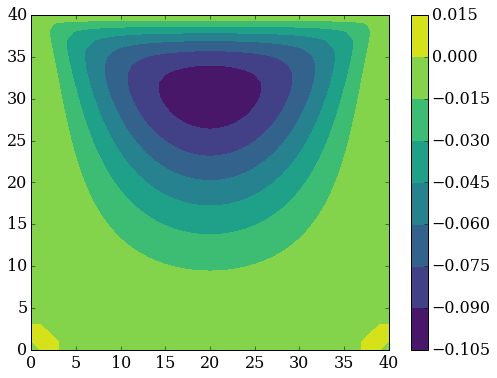

In [133]:
pyplot.figure(figsize=(8,6))
pyplot.contourf(psi_new,cmap=matplotlib.cm.viridis)
pyplot.colorbar();

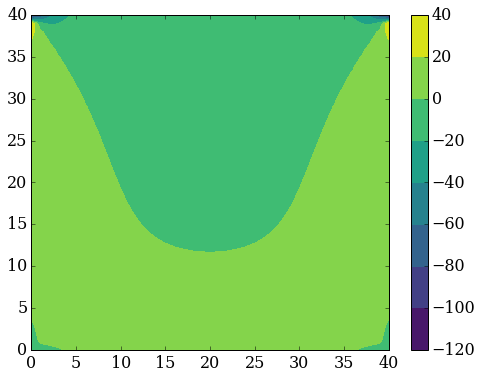

In [132]:
pyplot.figure(figsize=(8,6))
pyplot.contourf(wz_new,cmap=matplotlib.cm.viridis)
pyplot.colorbar();